In [6]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv(FILENAME, low_memory=False)

In [10]:
#Variables we care about
variables = ['epa','air_yards','cpoe','wpa']

#Groupby passer name, season, team
qbs = data.groupby(by=['passer_player_name','season','posteam'])[variables].mean()
#Get a couple of other variables that aren't averages
qbs['std_epa'] = data.groupby(by=['passer_player_name','season','posteam'])['epa'].std()
qbs['attempts'] = data.groupby(by=['passer_player_name','season','posteam'])['epa'].count()
#Only use QBs with over 128 attempts in a year (NGS uses this cutoff)
qbs = qbs.loc[qbs['attempts']>=128]
#reset the index so passer_player_name is a column and not an index
qbs.reset_index(inplace=True)
#Only get QBs who have more than one season of data (or there's nothing to correlate!)
qbs = qbs[qbs.groupby('passer_player_name').passer_player_name.transform('count') > 1]

In [13]:
#Shift the QB variables by 1 row for each QB
lqbs = qbs.groupby(by='passer_player_name').shift(-1)
#rename QB columns so we can join them
qbs.columns = ['passer_player_name','prev_season',
               'prev_posteam','prev_epa',
               'prev_air_yards',
               'prev_cpoe',
               'prev_wpa',
               'prev_std_epa',
               'prev_attempts']
#Join the lagged variables with the original dataframe
new_qbs = pd.concat((qbs,lqbs),axis=1).dropna(subset=['season'])

In [25]:
corr = new_qbs.corr(method='pearson')
#No same year correlations with this view, 
#just how variables in a previous year correlates to variables in the next year
corr.iloc[0:7,7:]

,season,epa,air_yards,cpoe,wpa,std_epa,attempts
prev_season,0.984138,0.145377,-0.125710,0.141899,0.185365,-0.209164,0.074739
prev_epa,0.141333,0.438611,-0.050306,0.412530,0.422899,-0.116292,0.453745
prev_air_yards,-0.022697,-0.085281,0.377505,-0.087875,-0.040237,0.108257,-0.022331
prev_cpoe,0.102638,0.406973,-0.039395,0.479885,0.418654,-0.043149,0.358892
prev_wpa,0.136250,0.375219,-0.042203,0.375475,0.384797,-0.103845,0.410943
prev_std_epa,-0.189344,-0.077922,0.151595,-0.050307,-0.012301,0.217870,-0.036583
prev_attempts,0.031066,0.427325,-0.071535,0.306384,0.372899,-0.110426,0.550554


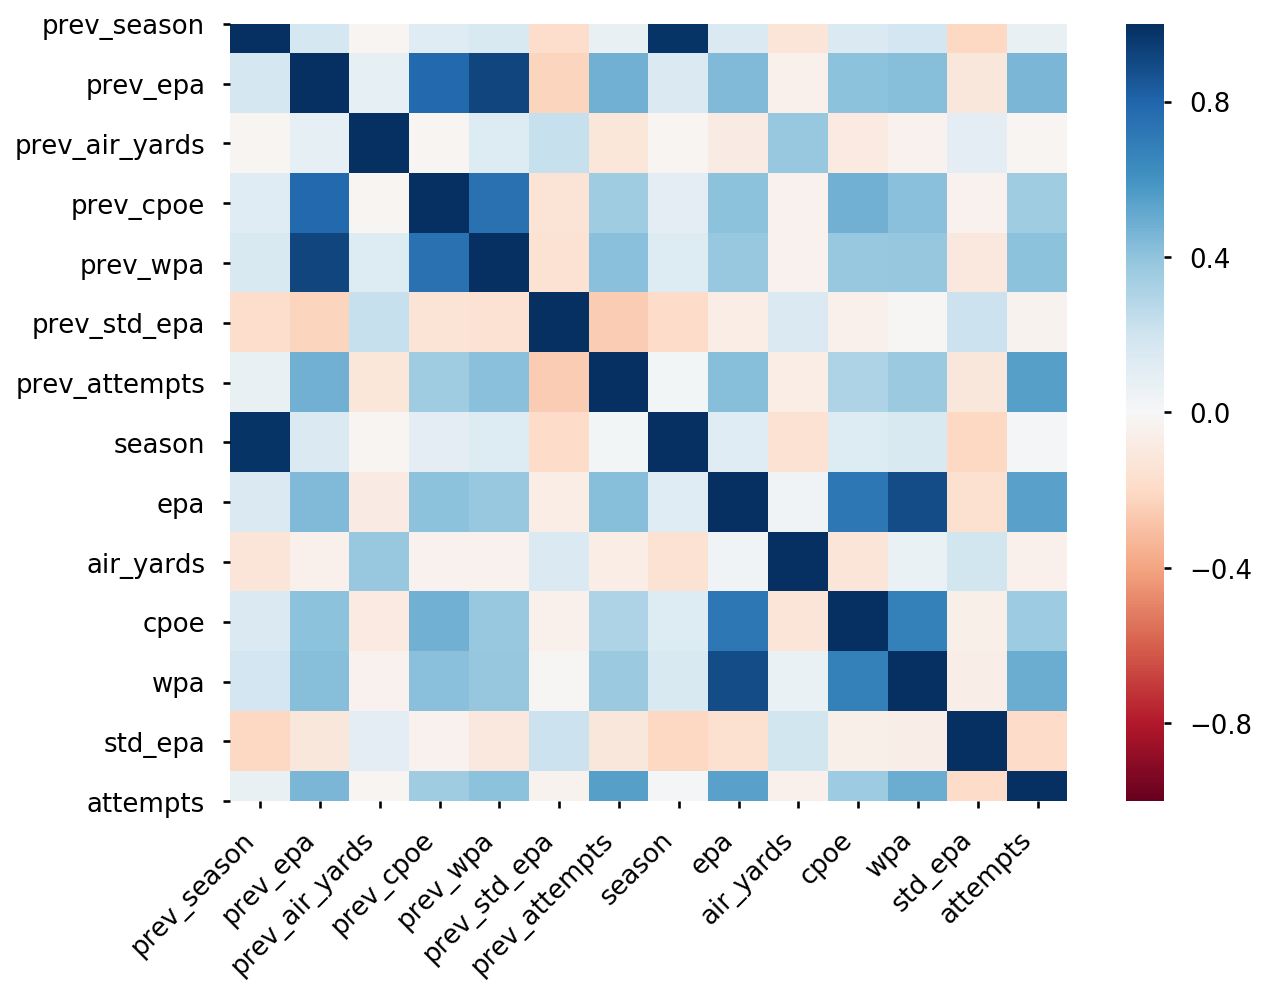

In [26]:
#Plotting
plt.style.use('seaborn-talk')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='RdBu',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);